
# MNIST functional API



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
inputs = keras.Input(shape=(784,))
dense = layers.Dense(64, activation="relu")
x = dense(inputs)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(10)(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")

In [ ]:
model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
history = model.fit(x_train, y_train, batch_size=64, epochs=2, validation_split=0.2)
test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/2
750/750 [==============================] - 4s 4ms/step - loss: 0.3414 - accuracy: 0.9024 - val_loss: 0.1930 - val_accuracy: 0.9419
Epoch 2/2
750/750 [==============================] - 3s 3ms/step - loss: 0.1645 - accuracy: 0.9505 - val_loss: 0.1389 - val_accuracy: 0.9590
313/313 - 0s - loss: 0.1358 - accuracy: 0.9593 - 365ms/epoch - 1ms/step
Test loss: 0.1358363926410675
Test accuracy: 0.9592999815940857


# Multiple Outputs

In [ ]:
encoder_input = keras.Input(shape=(28, 28, 1), name="original_img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

decoder_input = keras.Input(shape=(16,), name="encoded_img")
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

autoencoder_input = keras.Input(shape=(28, 28, 1), name="img")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name="autoencoder")
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 original_img (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 6, 6, 32)          9248      
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 16)          4624      
                                                           

# Implementation SSGAN 
* https://github.com/KunalVaidya99/Semi-Supervised-GAN/blob/master/Semi_Supervised_GAN.ipynb
* https://towardsdatascience.com/implementation-of-semi-supervised-generative-adversarial-networks-in-keras-195a1b2c3ea6

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense,Conv2D,Conv2DTranspose,Input,Reshape,Activation,Lambda
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization,Dropout,Flatten
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential,Model
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

img_rows = 28
img_cols = 28
channels = 1
 
img_shape = (img_rows,img_cols,channels)
 
z_dim = 100
num_classes = 10

11501568/11490434 [==============================] - 0s 0us/step
-1.0


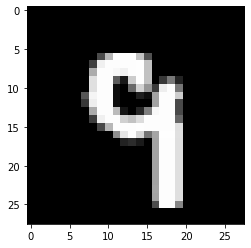

In [2]:
class Dataset:
  def __init__(self,num_labeled,num_classes):
    self.num_labeled = num_labeled
    self.num_classes = num_classes
    (self.x_train,self.y_train),(self.x_test,self.y_test) = mnist.load_data()      #loading mnist data
  
    def preprocess_image(x):
      x = (x.astype(np.float32)-127.5)/127.5      #preprocessing images to [-1,1] 
      x = np.expand_dims(x,axis=-1)
      return x
  
    def preprocess_labels(y):
      return y.reshape((-1,1))

    self.x_train = preprocess_image(self.x_train)
    print(np.min(self.x_train))
    self.y_train = preprocess_labels(self.y_train)
    self.x_test = preprocess_image(self.x_test)
    self.y_test = preprocess_labels(self.y_test)
 
  def batch_labeled(self,batch_size):
 
    sample_per_class = int(self.num_labeled/self.num_classes)
    imgs = list()
    labels = list()
    for i in range(sample_per_class):
      idx = self.y_train==i                             #getting indexes where y_train == i
      idx = [i for i, x in enumerate(idx) if x]
      x_classes= self.x_train[idx]
      y_classes = self.y_train[idx]
      #index = np.random.randint(0,x_classes.shape[0],sample_per_class)
      index = np.arange(sample_per_class)
      x_imgs = x_classes[index]                #taking 10 samples from the specific label 
      y_imgs = y_classes[index]
      
      #print(x_imgs.shape)
      [imgs.append(x_imgs[j]) for j in index ]
      [labels.append(y_imgs[j]) for j in range(num_classes)]
 
    imgs = np.asarray(imgs)
    labels = np.asarray(labels)
    #print(labels)
 
    ix  = np.random.randint(0,self.num_labeled,batch_size)
    imgs = imgs[ix]
    labels = labels[ix]
    #print(labels.shape)
    return imgs,labels
 
  def batch_unlabeled(self,batch_size):
    idx = np.random.randint(self.num_labeled,self.x_train.shape[0],batch_size)
    imgs = self.x_train[idx]
    return imgs
 
  def training_set(self):
     x_train = self.x_train[range(self.num_labeled)]  
     y_train = self.y_train[range(self.num_labeled)]
     return x_train ,y_train
  def testing_set(self):
    return self.x_test,self.y_test
 
num_labeled = 100
num_classes = 10
dataset = Dataset(num_labeled,num_classes)
i= dataset.batch_unlabeled(32)
plt.imshow(i[0,:,:,0],cmap='gray')

In [3]:
def build_generator(z_dim):
  model = Sequential()
  model.add(Dense(256*7*7,input_dim=z_dim))
  model.add(Reshape((7,7,256)))
  model.add(Conv2DTranspose(128,kernel_size=3,strides=2,padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))
  model.add(Conv2DTranspose(64,kernel_size=3,strides=1,padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.01))
  model.add(Conv2DTranspose(1,kernel_size=(3,3),strides=2,padding='same',activation='tanh'))
  ## using tanh activation gives better images

  return model

In [4]:
build_generator(100).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1266944   
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      295040    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 128)      512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 14, 14, 64)       7

In [5]:
def build_discriminator(img_shape):
  inp = Input(shape=img_shape)

  X = Conv2D(32,kernel_size=(3,3),strides=2,input_shape=img_shape,padding='same')(inp)
  X = LeakyReLU(alpha=0.01)(X)
  X = Conv2D(64,kernel_size=(3,3),strides=2,padding='same')(X)
  X = BatchNormalization()(X)
  X = LeakyReLU(alpha=0.01)(X)
  X = Conv2D(128,kernel_size=(3,3),strides=2,padding='same')(X)
  X = BatchNormalization()(X)
  X = LeakyReLU(alpha=0.01)(X)

  
  X = Flatten(name="flatten")(X)
  X = Dropout(0.5)(X)
  X = Dense(num_classes)(X)
  model = Model(inputs=inp,outputs=X)
  return model

  def build_discriminator_supervised(discriminator):
    model = Sequential()
    model.add(discriminator)
    model.add(Activation('softmax'))
    return model

In [6]:
def build_discriminator_supervised(discriminator):
  model = Sequential()
  model.add(discriminator)
  model.add(Activation('softmax'))
  return model


def build_discriminator_unsupervised(discriminator):
  model = Sequential()
  model.add(discriminator)
  def custom_activation(x):
        
    prediction = 1.0 - (1.0 /
                           (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
    return prediction
  model.add(Lambda(custom_activation))
  
  return model

def build_gan(generator,discriminator):
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  return model

In [7]:
discriminator = build_discriminator(img_shape)
discriminator_supervised = build_discriminator_supervised(discriminator)
discriminator_supervised.compile(optimizer= Adam(learning_rate=0.001),loss="categorical_crossentropy",metrics=['accuracy'])
discriminator_unsupervised = build_discriminator_unsupervised(discriminator)
discriminator_unsupervised.compile(optimizer = Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
generator = build_generator(z_dim)
discriminator_unsupervised.trainable = False
gan = build_gan(generator,discriminator_unsupervised)
gan.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [10]:
supervised_losses = []
iteration_checkpoints = []
accuracies = []
val_losses = []

from tensorflow.keras.utils import to_categorical
x_test,y_test = dataset.testing_set()
y_test = to_categorical(y_test,num_classes)

def train(iterations,batch_size,sample_interval):

  real = np.ones((batch_size,1))
  fake = np.zeros((batch_size,1))

  for iteration in range(iterations):
    imgs,labels = dataset.batch_labeled(batch_size)
    
    #print(labels)
    labels = to_categorical(labels,num_classes=num_classes)

    unlabeled_imgs = dataset.batch_unlabeled(batch_size)

    z = np.random.normal(0,1,(batch_size,z_dim))
    
    fake_imgs = generator.predict(z)
    #print(fake_imgs.shape)

    d_supervised_loss,accuracy = discriminator_supervised.train_on_batch(imgs,labels)
    d_unsupervised_loss_real = discriminator_unsupervised.train_on_batch(unlabeled_imgs,real)
    d_unsupervised_loss_fake = discriminator_unsupervised.train_on_batch(fake_imgs,fake)
    d_unsupervised_loss = 0.5*np.add(d_unsupervised_loss_real,d_unsupervised_loss_fake)

    z = np.random.normal(0,1,(batch_size,z_dim))
    fake_imgs = generator.predict(z)
    generator_loss = gan.train_on_batch(z,real)

    
    if(iteration+1) % sample_interval ==0:
      supervised_losses.append(d_supervised_loss)
      accuracies.append(100*accuracy)
      iteration_checkpoints.append(iteration+1)
      val_loss = discriminator_supervised.evaluate(x=x_test,y=y_test,verbose=0)
      val_losses.append(val_loss[0])
      print("Iteration No.:",iteration+1,end=",")
      print("Discriminator Supervised Loss:",d_supervised_loss,end=',')
      print('Generator Loss:',generator_loss,end=",")
      print('Discriminator Unsuperived Loss:',d_unsupervised_loss,sep=',')
      print('val_loss:',val_loss,sep=',')
      print('Accuracy Supervised:',100*accuracy)
      #sample_images(generator)

In [ ]:
iterations = 6000
batch_size = 32
sample_interval = 100
train(iterations,batch_size,sample_interval)

Iteration No.: 100,Discriminator Supervised Loss: 0.002665058709681034,Generator Loss: [0.052548736333847046, 1.0],Discriminator Unsuperived Loss:,[6.79806035e-04 1.00000000e+00]
val_loss:,[1.190253734588623, 0.6676999926567078]
Accuracy Supervised: 100.0
